In [30]:
import numpy as np
import pandas as pd
import os

%matplotlib inline
import matplotlib.pyplot as plt


import cv2

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

from keras import backend as K
from keras import layers, models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop, Nadam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, History, ReduceLROnPlateau, CSVLogger, LearningRateScheduler

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf


#explainibility plot LIME
import lime
from lime import lime_image
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries

from PIL import Image

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import h5py

In [3]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=0c001d9e1cb3016c16d1fd0f7475ef024013facdd06582a79e82725f01b22b7b
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
pip freeze > requirements.txt

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
#data_directory = 'Dataset/Train Dataset/WCEBleedGen'
data_directory='/content/drive/MyDrive/Auto WCEBleedGen Challenge Dataset/Train Dataset/WCEBleedGen'
os.listdir(data_directory)

['non-bleeding', 'bleeding']

In [7]:
def get_data(data_dir):
  X = []
  Y = []

  for category in os.listdir(data_dir):
    path = os.path.join(data_dir, category, 'Images')
    for images in os.listdir(path):
      imagePath = os.path.join(path, images)

      image = cv2.imread(imagePath)

    # Ensure the image is in RGB format (OpenCV reads in BGR format)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (224, 224))
      X.append(np.array(image))
      if category == 'bleeding':
        Y.append(1.0)
      else:
        Y.append(0.0)
  return X, Y

In [11]:
X, Y = get_data(data_directory)

In [12]:
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = to_categorical(Y, 2)
X = np.array(X)
X = X / 255

In [13]:
print(X.shape)
print(Y.shape)

(2618, 224, 224, 3)
(2618, 2)


In [ ]:
# df = get_data(data_directory)

In [ ]:
# df

In [ ]:
# Y = df['label']
# X = df.drop("label", axis = 1)

In [14]:
x_train, x_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.20, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.50, random_state=42)

In [15]:
# Define the CNN model
model = models.Sequential()

# Convolutional Layer 1 (C1)
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (224, 224, 3)))

# Max-Pooling Layer 1 (MP1)
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional Layer 2 (C2)
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
# Max-Pooling Layer 2 (MP2)
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional Layer 3 (C3)
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
# Max-Pooling Layer 3 (MP3)
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the feature maps
model.add(layers.Flatten())

# Fully Connected Layer 1 (FC1)
model.add(layers.Dense(64, activation = 'relu'))

# Fully Connected Layer 2 (FC2)
model.add(layers.Dense(2, activation = 'softmax'))


In [16]:
batch_size=64
epochs=20

#from keras.callbacks import ReduceLROnPlateau
#red_lr = ReduceLROnPlateau(monitor = 'val_acc', patience = 3, verbose = 1, factor = 0.1)

In [17]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [18]:
model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 64)        0

In [ ]:
w_path='/content/drive/MyDrive/Auto WCEBleedGen Challenge Dataset/'+'weights_cnn_v4.hdf5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=w_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='auto',
    verbose = 1,
    save_freq="epoch",
    save_best_only=True)
History = model.fit(datagen.flow(x_train,y_train, batch_size = batch_size),
                              epochs = epochs, validation_data = (x_val,y_val),
                              verbose = 1, steps_per_epoch = x_train.shape[0] // batch_size,
                              callbacks=[model_checkpoint_callback])

Epoch 1/20
32/32 [==============================] - ETA: 0s - loss: 0.6253 - accuracy: 0.6488
Epoch 1: val_accuracy improved from -inf to 0.82061, saving model to /content/drive/MyDrive/Auto WCEBleedGen Challenge Dataset/weights_cnn_v4.hdf5
32/32 [==============================] - 46s 933ms/step - loss: 0.6253 - accuracy: 0.6488 - val_loss: 0.3835 - val_accuracy: 0.8206
Epoch 2/20
32/32 [==============================] - ETA: 0s - loss: 0.4251 - accuracy: 0.8059
Epoch 2: val_accuracy improved from 0.82061 to 0.82443, saving model to /content/drive/MyDrive/Auto WCEBleedGen Challenge Dataset/weights_cnn_v4.hdf5
32/32 [==============================] - 25s 790ms/step - loss: 0.4251 - accuracy: 0.8059 - val_loss: 0.3612 - val_accuracy: 0.8244
Epoch 3/20
32/32 [==============================] - ETA: 0s - loss: 0.3813 - accuracy: 0.8271
Epoch 3: val_accuracy improved from 0.82443 to 0.86260, saving model to /content/drive/MyDrive/Auto WCEBleedGen Challenge Dataset/weights_cnn_v4.hdf5
32/32 [

In [20]:
model.load_weights('/content/drive/MyDrive/Auto WCEBleedGen Challenge Dataset/weights_cnn_v3.hdf5')

In [ ]:
pred=model.predict(x_test)

9/9 [==============================] - 8s 30ms/step


In [ ]:
pred

array([[5.1348930e-04, 9.9948645e-01],
       [4.6993354e-03, 9.9530065e-01],
       [9.9991786e-01, 8.2121827e-05],
       [1.9687236e-07, 9.9999976e-01],
       [6.9751090e-06, 9.9999297e-01],
       [6.1804475e-04, 9.9938190e-01],
       [9.9978250e-01, 2.1755707e-04],
       [2.0728192e-13, 1.0000000e+00],
       [4.2630495e-09, 1.0000000e+00],
       [1.3087266e-03, 9.9869126e-01],
       [9.9723119e-01, 2.7687803e-03],
       [5.9634125e-01, 4.0365881e-01],
       [9.9698859e-01, 3.0114411e-03],
       [9.9924016e-01, 7.5985520e-04],
       [9.9990380e-01, 9.6196854e-05],
       [5.5713511e-12, 1.0000000e+00],
       [9.9993145e-01, 6.8512840e-05],
       [2.5834318e-13, 1.0000000e+00],
       [3.0169450e-14, 1.0000000e+00],
       [9.8306274e-01, 1.6937289e-02],
       [1.7581742e-03, 9.9824178e-01],
       [4.3745892e-12, 1.0000000e+00],
       [9.9395037e-01, 6.0495944e-03],
       [9.9933368e-01, 6.6626654e-04],
       [9.9996781e-01, 3.2131484e-05],
       [4.0893613e-10, 1.

In [ ]:
prediction = np.argmax(pred, axis = 1)
prediction

array([1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1])

In [ ]:
true = np.argmax(y_test, axis = 1)
true

array([1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1])

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
report = classification_report(true, prediction)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       135
           1       0.97      0.91      0.94       127

    accuracy                           0.94       262
   macro avg       0.95      0.94      0.94       262
weighted avg       0.94      0.94      0.94       262



In [ ]:
label_mapping={0:'bleeding',
               1:'non_bledding'}

In [ ]:
def test_model(model, X_test, Y_test):
    model_acc = model.evaluate(X_test, Y_test, verbose=0)[1]
    print("Test Accuracy: {:.3f}%".format(model_acc * 100))
    y_true = np.argmax(Y_test, axis=1)
    y_pred = model.predict(X_test)
    y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
    clr = classification_report(y_true, y_pred,target_names=label_mapping.values())
    print(clr)
    sample_data = X_test[:15]
    plt.figure(figsize=(22, 12))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(sample_data[i])
        plt.title(label_mapping[y_true[i]] + '|' + label_mapping[y_pred[i]])
        plt.axis("off")
    plt.show()

Test Accuracy: 98.092%
9/9 [==============================] - 0s 20ms/step
              precision    recall  f1-score   support

    bleeding       0.98      0.99      0.98       135
non_bledding       0.98      0.98      0.98       127

    accuracy                           0.98       262
   macro avg       0.98      0.98      0.98       262
weighted avg       0.98      0.98      0.98       262



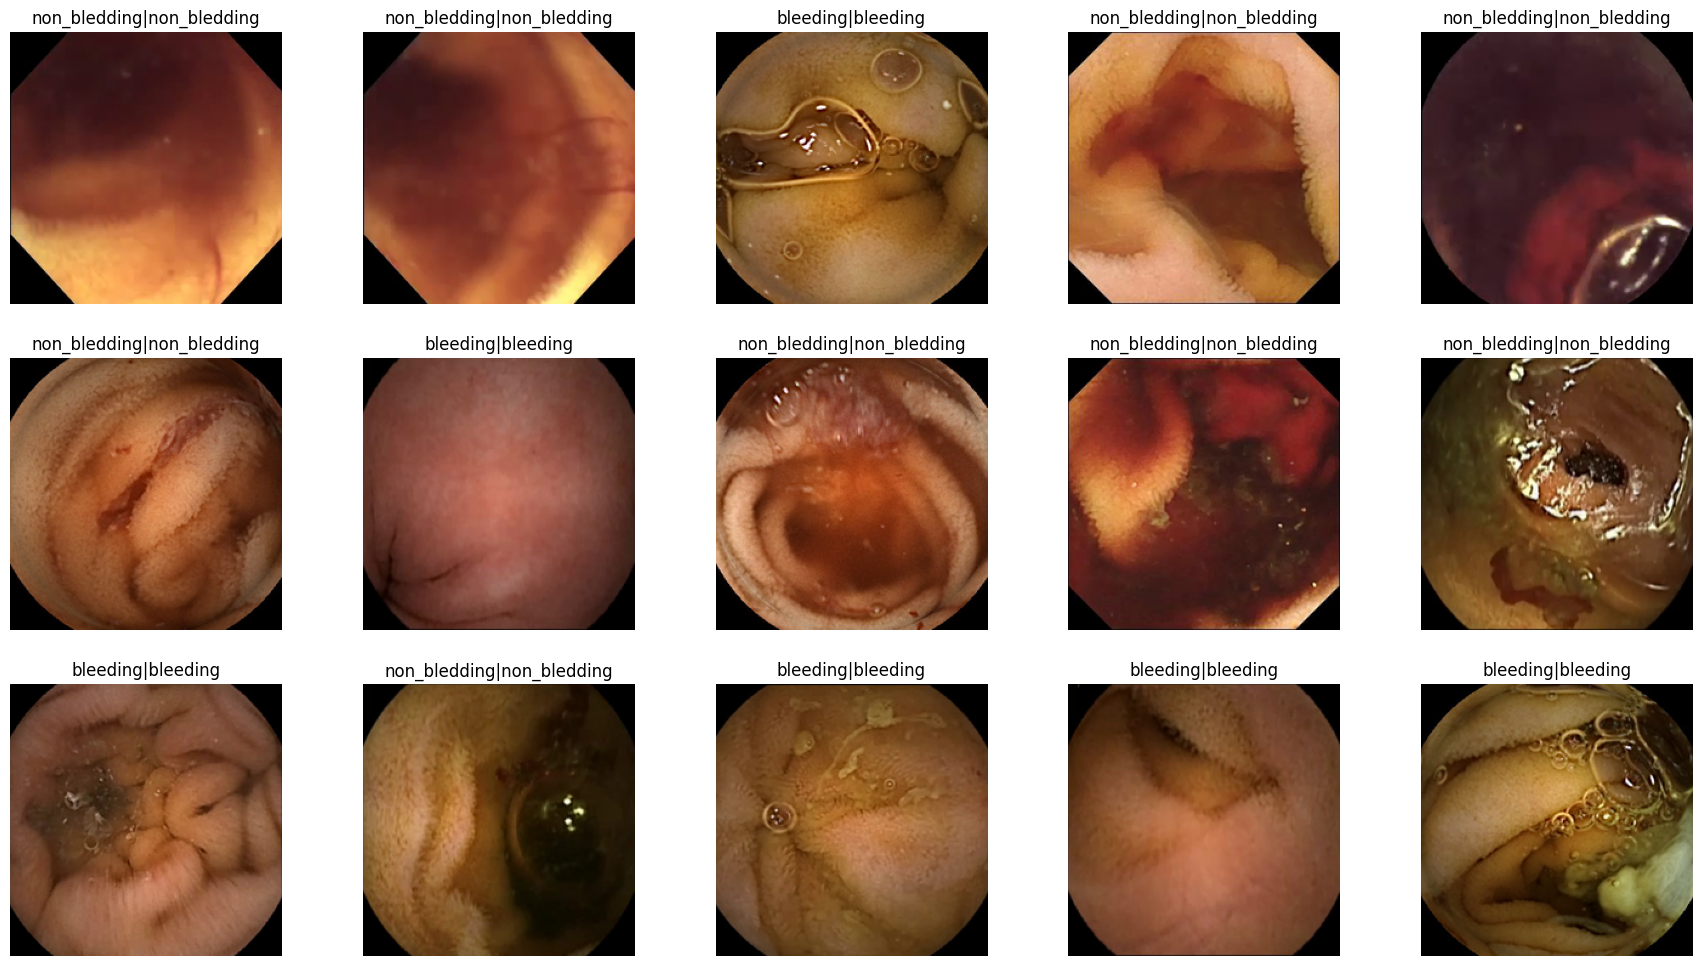

In [ ]:
test_model(model,x_test, y_test)

In [47]:
for i in os.listdir('/content/drive/MyDrive/Auto WCEBleedGen Challenge Dataset/Train Dataset/WCEBleedGen/bleeding/Images'):
  img_path = '/content/drive/MyDrive/Auto WCEBleedGen Challenge Dataset/Train Dataset/WCEBleedGen/bleeding/Images/'+i
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (224, 224))
  x = np.array(img)
  x = np.expand_dims(x, axis=0)


  class_index =  1

  # Get the output tensor corresponding to the final convolutional layer
  last_conv_layer = model.get_layer('conv2d_2')

  # Create a model that extracts features from the last convolutional layer and the output layer
  cam_model = tf.keras.models.Model(inputs=model.input,
                                    outputs=(last_conv_layer.output, model.output))

  # Get the feature map and predicted class probabilities
  with tf.GradientTape() as tape:
      last_conv_output, preds = cam_model(x)
      class_output = preds[:, class_index]

  # Compute the gradients of the class output with respect to the feature map
  grads = tape.gradient(class_output, last_conv_output)

  # Global average pooling to obtain the heatmap
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
  heatmap = tf.reduce_mean(last_conv_output, axis=-1)

  # Multiply each feature map by the corresponding gradient
  #for i in range(heatmap.shape[-1]):
      #heatmap[:, :, i] *= pooled_grads[i]

  # Average the weighted feature maps
  heatmap = np.mean(heatmap, axis=-1)
  heatmap = np.maximum(heatmap, 0)  # ReLU activation

  # Normalize the heatmap
  heatmap /= np.max(heatmap)
  original_img = cv2.imread(img_path)

  # Resize the heatmap to match the original image dimensions
  heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))

  # Convert heatmap to a color map (jet colormap)
  jet_heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

  # Overlay the heatmap on the original image
  superimposed_img = jet_heatmap * 0.4 + original_img * 0.6  # Adjust alpha values for blending

  # Save or display the superimposed image with the heatmap
  cv2.imwrite('/content/drive/MyDrive/Auto WCEBleedGen Challenge Dataset/Outputs/'+i, superimposed_img)
  #plt.imshow(superimposed_img)
  #plt.axis('off')
  #plt.show()
